In [60]:
import pandas as pd
import sqlite3
import os

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
directory = os.path.abspath(os.path.join(os.getcwd(), os.pardir))

# Tools

In [8]:
def pid_count(df, *the_rest):
    def _cal(df):
        return len(df.drop_duplicates('pid'))
    print(*list(map(_cal, [df]+list(the_rest))), sep=', ')

In [4]:
def save_db(db_name, df_name, *path):
    if len(path) == 1:
        conn_save = sqlite3.connect(directory + path[0] + db_name + '.db')
    else:
#         conn_save = sqlite3.connect(directory + '/' + db_name + '.db')
        conn_save = sqlite3.connect(directory + '/dataPrep/source/overall/' + db_name + '.db')
    df_name.to_sql(name=db_name, con=conn_save, if_exists='replace', index=False)

In [5]:
def check_keywords(test_df, keywords):
    df = test_df.copy()
    df = df.apply(lambda row: any(x in row.cmt_content for x in keywords), axis=1)
    return df

In [55]:
def describe_table(df):
    table = df.groupby('proj_category').mean()[['proj_backer_count']].rename(
    columns={'proj_backer_count': 'Mean'}).reset_index().merge(
    df.groupby('proj_category').min()[['proj_backer_count']].rename(
        columns={'proj_backer_count': 'Min'}).reset_index(), 
    on=['proj_category']).merge(
    df.groupby('proj_category').quantile(.25)[['proj_backer_count']].rename(
        columns={'proj_backer_count': 'Q1'}).reset_index(), 
    on=['proj_category']).merge(
    df.groupby('proj_category').quantile(.5)[['proj_backer_count']].rename(
        columns={'proj_backer_count': 'Q2'}).reset_index(), 
    on=['proj_category']).merge(
    df.groupby('proj_category').quantile(.75)[['proj_backer_count']].rename(
        columns={'proj_backer_count': 'Q3'}).reset_index(),
    on=['proj_category']).merge(    
    df.groupby('proj_category').max()[['proj_backer_count']].rename(
        columns={'proj_backer_count': 'Max'}).reset_index(), 
    on=['proj_category']).merge(
    df.groupby('proj_category').count()[['pid']].rename(
        columns={'pid': 'Total'}).reset_index(), on=['proj_category'])
    return table

# Data

In [47]:
conn_cmt_rmO_lm_b03 = sqlite3.connect(directory + '/dataPrep/source/overall/' + 'cmt_rmO_lm_b03.db')
cmt_rmO_lm_b03 = pd.read_sql_query("SELECT * FROM cmt_rmO_lm_b03", conn_cmt_rmO_lm_b03)

In [64]:
conn_cmt_year = sqlite3.connect(directory + '/dataPrep/source/ds_ind_26229/' + 'cmt_year.db')
cmt_year = pd.read_sql_query("SELECT * FROM cmt_year", conn_cmt_year)

# Check Keywords and Phrases

In [65]:
pid_count(cmt_rmO_lm_b03, cmt_year)

2137, 11042


In [29]:
cmt_year = cmt_year[cmt_year.pid.isin(cmt_rmO_lm_b03.pid)]

In [30]:
pid_count(cmt_year)

2137


In [15]:
cmt_year_bac = cmt_year[cmt_year.cmt_collaborator == 0].copy()
# must transform to lowercase !
cmt_year_bac['cmt_content'] = cmt_year_bac.cmt_content.str.lower() 

In [16]:
yet2receive = ['yet to receive', 'haven\'t received', 'not receive', 'no received', # receive
               'can\'t receive', 'when can i receive', 'when am i receiving', 'when i should receive', 
               'when ship', 'when are you ship',
               'when will i be receiving', 'who have receive', 'who has received', 'anyone receive', 
               ' didn\'t receive', 'never receive', 'received nothing', 'nothing receive',
               'still wait', 'still no', 'nothing at all', 'nothing yet', 'nothing has appeared',  # nothing
               'nothing here', 'nothing in yet',
               'n\'t see anything',
               'what about shipment', 'when will i get', 'when is shipping', 'when mine will be shipped',  # ship
               'not ship', 'no ship', 'shipment?',
               'tired of waiting', 'still waiting', 'awaiting', 'wait longer','where is my', 'where\'s my',
               'never got', 'no product', 'not get', 'not got', 'n\'t get', 'n\'t got', 'anyone already get',
               'n\'t seen', 'not seen', 'n\'t arrive', 'not arrive', 'never arrive',
               'forgotten', 'delay', 'yet to be delivered', 'no deliver', 'never deliver',
               'no tracking', 'never fulfilled']

dissatisfy = ['worse', 'faulty', 'fail', 'damaged', 'busted', 'broken', 'destroyed', 'defective', 
              'disaster', 'crap', 'poor', 'terrible', 'dud', 'shoddy', 'worthless', 'garbage', 
              'junk', 'trash', 'never work', 'n\'t work', 'joke', 'kidding', 'awful', 'ridiculous', 
              'bullshit', 'humbug', 'ripoff', 'rip-off', 'ripped',  'not test', # about reward
              'worst experience', 'disappointed', 'disappointment', 'disappointing', # about feeling
              'unhappy', 'not fun', 'regret pledg', 'upset', 'never trust', 'frustrating',
              'lack of communication', 'no communication', 'no repl', 'not repl',  # about reply
              'never repl', 'no answers', 'not respon', 'no respon', 'never respon', 
              'no update', 'any update', 'please update', 'update please', 'no mail',
              'unhelpful', 'useless', ':(']

other = ['asshole', 'thief', 'thieve','shame', 'disgrace', 'scam', 'fraud', 'lawsuit', 'lawyer',
         'can i get a refund', 'can we get refund', 'refund option ', 'like a refund', 'demanding a refund',
         'no refund', 'back the money', 'want a refund', 'waste of money', 'want my money back', 
         'want what i paid for', 'against kickstarter', 'wake kickstarter'] 

In [18]:
cmt_year_bac['neg_1'] = check_keywords(cmt_year_bac, yet2receive)
cmt_year_bac['neg_2'] = check_keywords(cmt_year_bac, dissatisfy)
cmt_year_bac['neg_3'] = check_keywords(cmt_year_bac, other)
cmt_year_bac['neg_2_3'] = check_keywords(cmt_year_bac, dissatisfy + other) # severity
cmt_year_bac['neg_all'] = check_keywords(cmt_year_bac, yet2receive + dissatisfy + other)

In [19]:
neg_1_count = cmt_year_bac[cmt_year_bac.neg_1 == True].groupby('pid').neg_1.count()
neg_2_count = cmt_year_bac[cmt_year_bac.neg_2 == True].groupby('pid').neg_2.count()
neg_3_count = cmt_year_bac[cmt_year_bac.neg_3 == True].groupby('pid').neg_3.count()
neg_2_3_count = cmt_year_bac[cmt_year_bac.neg_2_3 == True].groupby('pid').neg_2_3.count()
neg_all_count = cmt_year_bac[cmt_year_bac.neg_all == True].groupby('pid').neg_all.count()


cmt_bac_count = cmt_year_bac.groupby('pid').count().cmt_content
cmt_bac_count = pd.DataFrame({'pid': cmt_bac_count.index, 'backer_cmt': cmt_bac_count, 
                              'neg_1': neg_1_count, 'neg_1_rate': neg_1_count/cmt_bac_count,
                              'neg_2': neg_2_count, 'neg_2_rate': neg_2_count/cmt_bac_count,
                              'neg_3': neg_3_count, 'neg_3_rate': neg_3_count/cmt_bac_count,
                              'neg_2_3': neg_2_3_count, 'neg_2_3_rate': neg_2_3_count/cmt_bac_count,
                              'neg_all': neg_all_count, 'neg_all_rate': neg_all_count/cmt_bac_count})

In [72]:
stat = cmt_bac_count.merge(cmt_year.groupby('pid').count().reset_index()[['cmt_content', 'pid']], on=['pid']).copy()
stat = stat.rename(columns={'cmt_content': 'cmt_total'})

stat['backer_rate'] = stat.backer_cmt/stat.cmt_total
stat = stat.merge(cmt_rmO_lm_b03[['pid', 'proj_backer_count', 'proj_category']], on=['pid'])
stat = stat[['pid', 'proj_category', 'cmt_total', 'backer_cmt', 'backer_rate', 
             'proj_backer_count',
             'neg_1', 'neg_2', 'neg_3', 'neg_all', 'neg_2_3', 
             'neg_1_rate', 'neg_2_rate', 'neg_3_rate',
             'neg_all_rate', 'neg_2_3_rate']]#.sort_values('neg_3_rate', ascending=False)

In [81]:
rmO_lm_b03 = stat.copy()
save_db('rmO_lm_b03', rmO_lm_b03)

In [76]:
rmO_lm_b03_neg = stat[stat.neg_all > stat.proj_backer_count*.03] # 762
rmO_lm_b03_pos = stat[~stat.pid.isin(neg_rmO_lm_b03.pid)] #1,375

In [79]:
describe_table(rmO_lm_b03_neg)

,proj_category,Mean,Min,Q1,Q2,Q3,Max,Total
0,art,108.894737,61.0,79.00,97.0,131.00,191.0,19
1,comics,216.842105,126.0,138.00,177.0,258.00,466.0,19
2,crafts,105.375000,57.0,60.50,90.5,135.50,201.0,16
3,design,479.542453,217.0,273.50,412.0,634.50,1041.0,212
4,fashion,208.557377,104.0,133.00,182.0,272.00,406.0,61
5,film & video,229.250000,115.0,142.25,256.0,304.50,318.0,8
6,food,240.500000,127.0,160.00,212.5,323.75,377.0,10
7,games,703.242038,315.0,458.00,629.0,909.00,1398.0,157
8,music,111.727273,74.0,80.50,105.0,132.00,182.0,11
9,photography,160.857143,98.0,122.50,133.0,185.00,280.0,7


In [83]:
save_db('rmO_lm_b03_neg', rmO_lm_b03_neg)

In [84]:
rmO_lm_b03_neg.head(1)

,pid,proj_category,cmt_total,backer_cmt,backer_rate,proj_backer_count,neg_1,neg_2,neg_3,neg_all,neg_2_3,neg_1_rate,neg_2_rate,neg_3_rate,neg_all_rate,neg_2_3_rate
0,1000232288,games,184,146,0.793478,448.0,14.0,11.0,2.0,24.0,13.0,0.09589,0.075342,0.013699,0.164384,0.089041


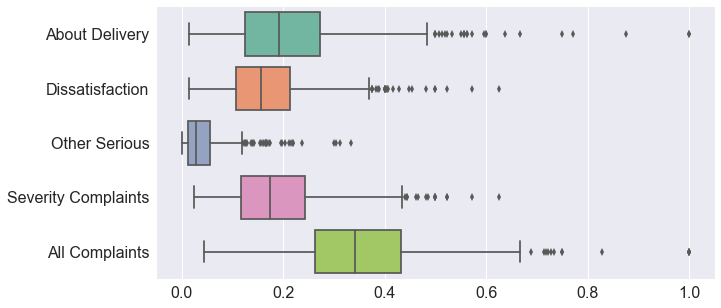

In [63]:
ax = plt.subplots(figsize=(10, 5))
sns.set(font_scale=1.6)

data = neg_rmO_lm_b03[['neg_1_rate', 'neg_2_rate', 'neg_3_rate', 'neg_2_3_rate','neg_all_rate']].rename(
    columns={'neg_1_rate': 'About Delivery',
             'neg_2_rate': 'Dissatisfaction',
             'neg_3_rate': 'Other Serious',
             'neg_2_3_rate': 'Severity Complaints',
             'neg_all_rate': 'All Complaints'})
ax = sns.boxplot(data=data, orient="h", palette="Set2")